In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [10]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=7)
#
client = Client(cluster)

In [11]:
ds_mean0 = xr.merge([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_lpass_filtered_mean1.zarr'),
                     xr.open_zarr(ut.work_data_dir+'filtered_itide/SSV_lpass_filtered_mean1.zarr')])
#dsU = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered.zarr')

In [12]:
grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]
grd = grd.sel(i=slice(0,None,4),j=slice(0,None,4))

/dev/shm/pbs.370772.datarmor0/ipykernel_15555/1540678595.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]


In [13]:
ds_mean0['Depth'] = grd.Depth
ds_mean0['lon'] = 0*ds_mean0.face+grd.XC
ds_mean0['lat'] = 0*ds_mean0.face+grd.YC

#ds_low_V['Depth'] = grd.Depth
#ds_low_V['lon'] = 0*ds_low_V.face+grd.XC
#s_low_V['lat'] = 0*ds_low_V.face+grd.YC

#ds_low_U['Depth'] = grd.Depth
#ds_low_U['lon'] = 0*ds_low_U.face+grd.XC
#ds_low_U['lat'] = 0*ds_low_U.face+grd.YC

In [6]:
ds_mean0

<xarray.Dataset>
Dimensions:      (face: 13, j: 1080, i: 1080, time: 2880)
Coordinates:
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i            (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j            (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * time         (time) datetime64[ns] 2011-11-15 ... 2012-11-08T21:00:00
Data variables:
    SSU_rot_hat  (face, j, i, time) float64 dask.array<chunksize=(1, 100, 100, 2880), meta=np.ndarray>
    SSV_rot_hat  (face, j, i, time) float64 dask.array<chunksize=(1, 100, 100, 2880), meta=np.ndarray>
    Depth        (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lon          (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lat          (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

In [14]:
energy_low_SSV = (ds_mean0.SSV_rot_hat**2).mean('time').persist()

In [15]:
energy_low_SSU = (ds_mean0.SSU_rot_hat**2).mean('time').persist()

In [16]:
energy_low = (ds_mean0.SSU_rot_hat**2+ds_mean0.SSV_rot_hat**2).mean('time').persist()

distributed.stealing - ERROR - Unexpected task state: missing
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/stealing.py", line 355, in move_task_confirm
    raise ValueError(f"Unexpected task state: {state}")
ValueError: Unexpected task state: missing
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x2aabcac58970>>, <Task finished name='Task-525757' coro=<WorkStealing.move_task_confirm() done, defined at /home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/stealing.py:284> exception=ValueError('Unexpected task state: missing')>)
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco

In [10]:
mean_low_SSU = (ds_mean0.SSU_rot_hat).mean('time').persist()
mean_low_SSV = (ds_mean0.SSV_rot_hat).mean('time').persist()
#mean_low = (ds_mean0.SSU_rot_hat+ds_mean0.SSV_rot_hat).mean('time').persist()

In [11]:
variance_low_SSU = ((ds_mean0.SSU_rot_hat-mean_low_SSU)**2).mean('time').persist()

In [12]:
variance_low_SSV = ((ds_mean0.SSV_rot_hat-mean_low_SSV)**2).mean('time').persist()

In [9]:
low = xr.Dataset({#'variance_SSU':variance_low_SSU,'variance_SSV':variance_low_SSV,
                  'energy_SSV':energy_low_SSV,'energy_SSU':energy_low_SSU,'energy':energy_low,
                  'lon':ds_mean0.lon,'lat':ds_mean0.lat}).assign_coords({'XC':grd.XC,'YC':grd.YC})
low

<xarray.Dataset>
Dimensions:     (face: 13, i: 1080, j: 1080)
Coordinates:
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i           (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j           (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    XC          (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    YC          (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
Data variables:
    energy_SSV  (face, j, i) float64 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    energy_SSU  (face, j, i) float64 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    energy      (face, j, i) float64 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    lon         (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lat         (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

In [10]:
ut.store_diagnostic('Eulerian_low_variance',low,overwrite=True)

data stored in /home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_low_variance.zarr


/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

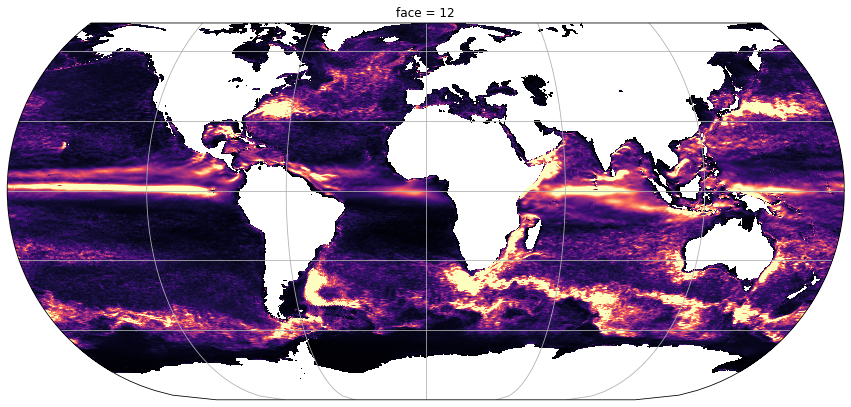

In [16]:
pl.plot_pretty(low.variance_SSU,cmap='magma',vmax=0.1,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

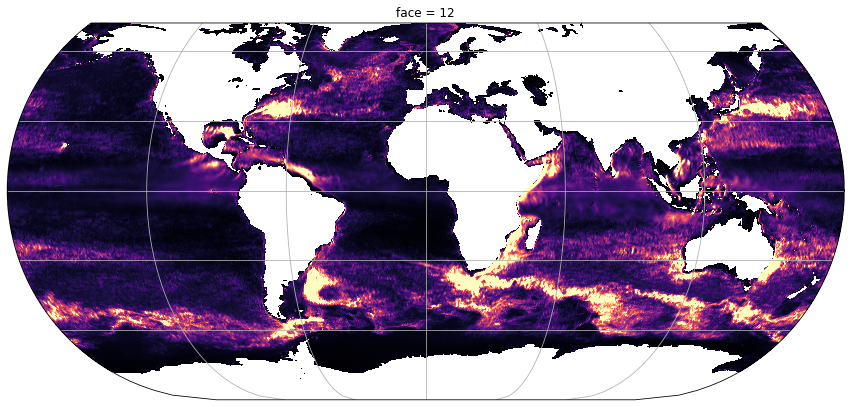

In [17]:
pl.plot_pretty(low.variance_SSV,cmap='magma',vmax=0.1,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

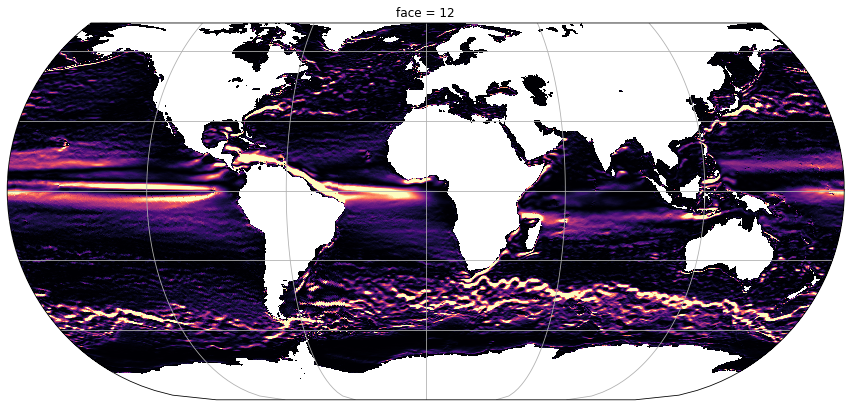

In [13]:
pl.plot_pretty(low.MKE,cmap='magma',vmax=0.1,land=False
              )

In [18]:
client.restart()

<Client: 'tcp://10.148.0.202:50135' processes=10 threads=10, memory=223.50 GiB>

In [32]:
dsU = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered.zarr')
dsV = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSV_filtered.zarr')

grd = grd.sel(i=slice(0,None,4),j=slice(0,None,4))
dsU['Depth'] = grd.Depth
dsU['lon'] = 0*dsU.face+grd.XC
dsU['lat'] = 0*dsU.face+grd.YC

dsV['Depth'] = grd.Depth
dsV['lon'] = 0*dsV.face+grd.XC
dsV['lat'] = 0*dsV.face+grd.YC

In [9]:
amplitude_real_V = ds.SSV_rot_demodulated.real.mean('time').persist()

In [10]:
amplitude_imag = ds.SSV_rot_demodulated.imag.mean('time').persist()

In [37]:
mean_hf_SSU = dsU.SSU_rot_demodulated.mean('time').persist()

In [28]:
mean_hf_SSV = dsV.SSV_rot_demodulated.mean('time').persist()

In [33]:
energy_hf_SSV = (np.abs(dsV.SSV_rot_demodulated)**2).mean('time').persist()


In [34]:
energy_hf_SSU = (np.abs(dsU.SSU_rot_demodulated)**2).mean('time').persist()

In [19]:
variance_hf = (np.abs(residual)**2).mean('time').persist()

In [35]:
hf = xr.Dataset({#'mean_SSU':mean_hf_SSU,'mean_SSV':mean_hf_SSV,
                    'energy_SSU' : energy_hf_SSU,'energy_SSV' : energy_hf_SSV,'lon':ds.lon,'lat':ds.lat
                     }).assign_coords({'XC':grd.XC,'YC':grd.YC})

In [36]:
ut.store_diagnostic('Eulerian_hf_energy',hf,overwrite=True)

data stored in /home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_hf_energy.zarr


/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

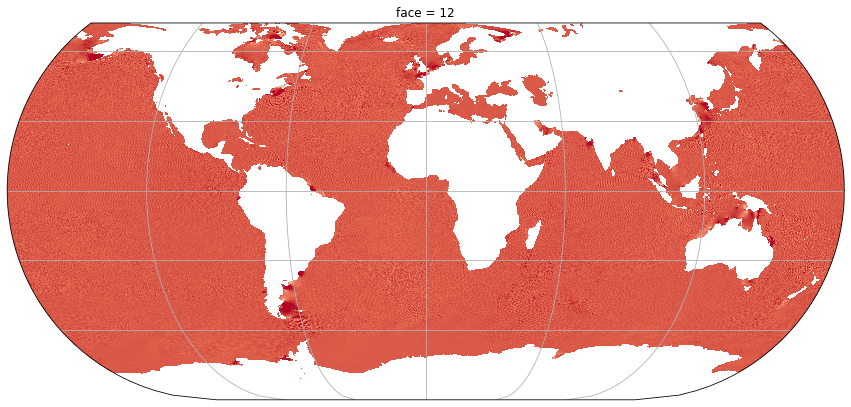

In [15]:
pl.plot_pretty(ds_ampl.ampl_real,cmap='coolwarm',vmax=0.02,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

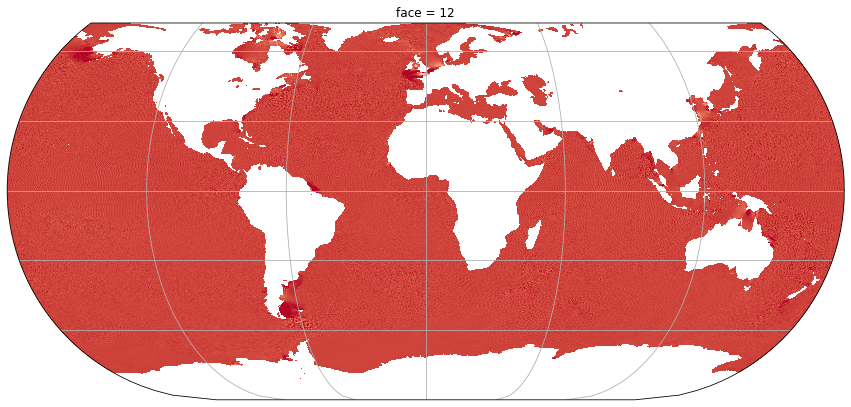

In [16]:
pl.plot_pretty(ds_ampl.ampl_imag,cmap='coolwarm',vmax=0.02,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

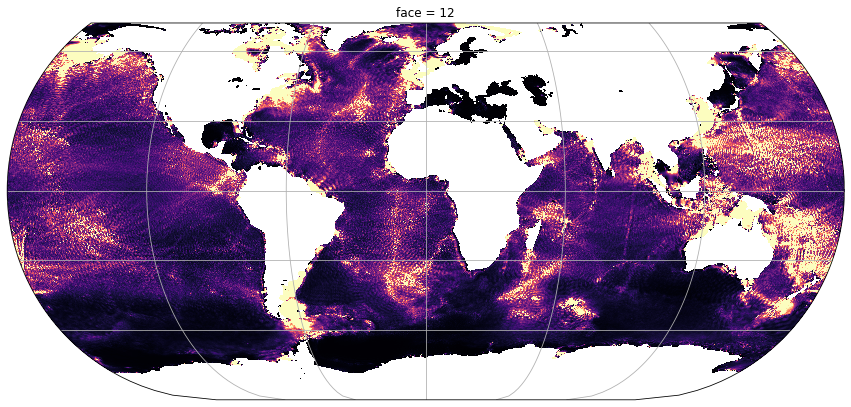

In [35]:
pl.plot_pretty(ds_ampl.variance_IT,cmap='magma',vmax=0.02,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

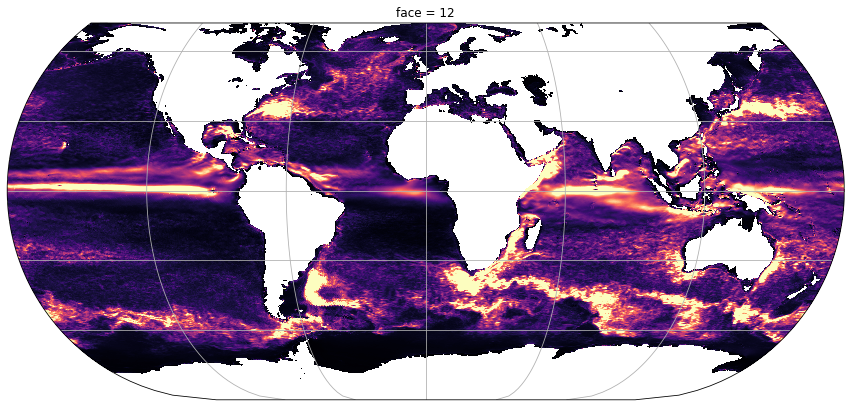

In [37]:
pl.plot_pretty(ds_ampl.variance_low,cmap='magma',vmax=0.1,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

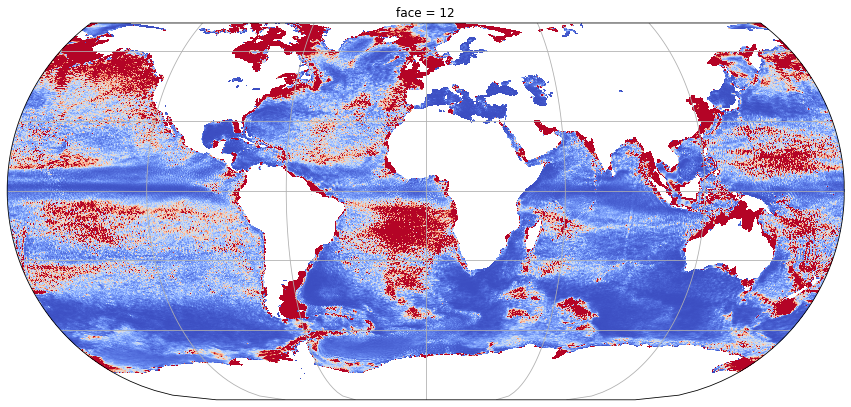

In [18]:
pl.plot_pretty(ds_ampl.variance_IT/ds_ampl.variance_low,cmap='coolwarm',vmax=1.,land=False
              )

### Binned variance : 

In [27]:
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

In [28]:
N = histogram(ds_ampl.lon.rename('lon'), ds_ampl.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

In [29]:
ds_binned = (histogram(ds_ampl.lon.rename('lon'), ds_ampl.lat.rename('lat'),bins=[lon_bins, lat_bins], weights=ds_ampl.variance_IT.fillna(0.),
                       dim=['i', 'j', 'face'])/(N)).rename('variance_itide').persist()

In [30]:
ds_binned_low = (histogram(ds_ampl.lon.rename('lon'), ds_ampl.lat.rename('lat'),bins=[lon_bins, lat_bins], weights=ds_ampl.variance_low.fillna(0.),
                       dim=['i', 'j', 'face'])/(N)).rename('variance_low').persist()

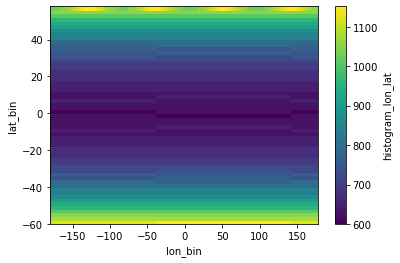

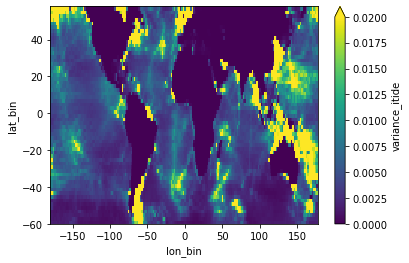

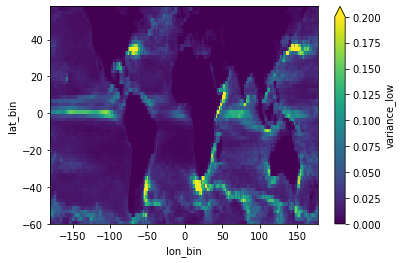

In [31]:
N.plot(y='lat_bin')
plt.figure()
ds_binned.plot(y='lat_bin',vmax=0.02)
plt.figure()
ds_binned_low.plot(y='lat_bin',vmax=0.2)

In [32]:
ds_out = xr.merge([ds_binned,ds_binned_low,N.rename('count')])
ds_out = ds_out.rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'})
ds_out

<xarray.Dataset>
Dimensions:         (lon_bins: 179, lat_bins: 59)
Coordinates:
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
  * lat_bins        (lat_bins) float64 -59.0 -57.0 -55.0 ... 53.0 55.0 57.0
Data variables:
    variance_itide  (lon_bins, lat_bins) float64 dask.array<chunksize=(179, 59), meta=np.ndarray>
    variance_low    (lon_bins, lat_bins) float64 dask.array<chunksize=(179, 59), meta=np.ndarray>
    count           (lon_bins, lat_bins) int64 dask.array<chunksize=(179, 59), meta=np.ndarray>

In [33]:
ds_out.attrs.update({'binsize':dl})
ds_out = ds_out.compute()

In [34]:
_ = ds_out.to_netcdf(path='/home1/datawork/zcaspar/mit4320/Evariance_2dl.nc')

In [17]:
cluster.close()

distributed.scheduler - ERROR - <TaskState 'open_dataset-b392895ae3f7c372673977f02f4468acSSU_rot_hat-cdbcd94b2636d26bfef2d8a2ab9e5b37' no-worker>
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3217, in transition_no_worker_released
    self._unrunnable.remove(ts)
KeyError: <TaskState 'open_dataset-b392895ae3f7c372673977f02f4468acSSU_rot_hat-cdbcd94b2636d26bfef2d8a2ab9e5b37' no-worker>
distributed.scheduler - ERROR - Error transitioning 'open_dataset-b392895ae3f7c372673977f02f4468acSSU_rot_hat-cdbcd94b2636d26bfef2d8a2ab9e5b37' from 'no-worker' to 'released'
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 2277, in _transition
    recommendations, client_msgs, worker_msgs = func(key, *args, **kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distribu